In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

## Prepare Data set

In [2]:
Data_Base_Path = './datas/UCR_TS_Archive_2015'

In [3]:
import os
flist = [x for x in os.listdir(Data_Base_Path) if os.path.isdir(os.path.join(Data_Base_Path, x))]
flist.sort(key=str.lower)
for index, name in enumerate(flist):
    print("%d: %s"%(index, name))

0: 50words
1: Adiac
2: ArrowHead
3: Beef
4: BeetleFly
5: BirdChicken
6: Car
7: CBF
8: ChlorineConcentration
9: CinC_ECG_torso
10: Coffee
11: Computers
12: Cricket_X
13: Cricket_Y
14: Cricket_Z
15: DiatomSizeReduction
16: DistalPhalanxOutlineAgeGroup
17: DistalPhalanxOutlineCorrect
18: DistalPhalanxTW
19: Earthquakes
20: ECG200
21: ECG5000
22: ECGFiveDays
23: ElectricDevices
24: FaceAll
25: FaceFour
26: FacesUCR
27: FISH
28: FordA
29: FordB
30: Gun_Point
31: Ham
32: HandOutlines
33: Haptics
34: Herring
35: InlineSkate
36: InsectWingbeatSound
37: ItalyPowerDemand
38: LargeKitchenAppliances
39: Lighting2
40: Lighting7
41: MALLAT
42: Meat
43: MedicalImages
44: MiddlePhalanxOutlineAgeGroup
45: MiddlePhalanxOutlineCorrect
46: MiddlePhalanxTW
47: MoteStrain
48: NonInvasiveFatalECG_Thorax1
49: NonInvasiveFatalECG_Thorax2
50: OliveOil
51: OSULeaf
52: PhalangesOutlinesCorrect
53: Phoneme
54: Plane
55: ProximalPhalanxOutlineAgeGroup
56: ProximalPhalanxOutlineCorrect
57: ProximalPhalanxTW
58: Refr

In [4]:
dataset_index = 1
dataset_name = flist[dataset_index]
print(dataset_name)

Adiac


In [5]:
epsilon = 1e-8

In [6]:
def readData(filename):
    data = np.loadtxt(filename, delimiter = ',')
    Y = data[:,0]
    X = data[:,1:]
    return X, Y

In [7]:
X_train, Y_train = readData('%s/%s/%s_TRAIN'%(Data_Base_Path, dataset_name, dataset_name))
X_test, Y_test = readData('%s/%s/%s_TEST'%(Data_Base_Path, dataset_name, dataset_name))
series_length = X_train.shape[1]
nb_classes = len(np.unique(Y_train))
N_train = X_train.shape[0]
N_test = X_test.shape[0]
Y_train = (Y_train - Y_train.min()) / (Y_train.max() - Y_train.min()) * (nb_classes - 1)
Y_test = (Y_test - Y_test.min()) / (Y_test.max() - Y_test.min()) * (nb_classes - 1)

## Normalization
X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train = (X_train - X_train_mean) / (X_train_std + epsilon)
X_test = (X_test - X_train_mean) / (X_train_std + epsilon)

In [8]:
print('''Series length: %d
Classes number: %d
Train set Number: %d
Test set Number: %d'''%(series_length, nb_classes, N_train, N_test))

Series length: 176
Classes number: 37
Train set Number: 390
Test set Number: 391


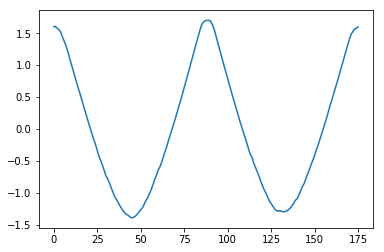

In [9]:
plt.plot(X_train[0,:])

## MFD Layers

In [10]:
import keras
from keras.engine.topology import Layer
import tensorflow as tf

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [11]:
class MRFFT(Layer):
    def compute_output_shape(self,input_shape):
        o_shape=[input_shape]*2
        return o_shape
    def call(self,inputs):
        t=tf.unstack(inputs,axis=2)
        ft=[tf.expand_dims(tf.spectral.rfft(k),-1) for k in t]
        ft=tf.concat(ft,-1)
        ift=tf.imag(ft)
        return [rft,ift]
class MIRFFT(Layer):
    def compute_output_shape(self,input_shape):
        return input_shape[0]
    def call(self,inputs):
        rft=inputs[0]
        ift=inputs[1]
        ft=tf.complex(rft,ift)
        t=tf.unstack(ft,axis=2)
        tt=[tf.expand_dims(tf.spectral.irfft(k),-1) for k in t]
        tt=tf.concat(tt,-1)
        return tt
class MFD_FFT(Layer):
    def __init__(self,in_shape,num_p,**kwargs):
        self.num_p = num_p
        self.in_shape=in_shape
        super(MFD_FFT,self).__init__(**kwargs)
        
    def compute_output_shape(self,input_shape):
        o_shape=input_shape[:2]+(self.num_p,input_shape[-1],)
        return o_shape
    
    def call(self,inputs):
        t=tf.unstack(inputs,axis=2)
        ft=[tf.expand_dims(tf.spectral.rfft(k),-1) for k in t]
        ft=tf.concat(ft,-1)
        fshape=self.in_shape
        
        m=fshape%self.num_p
        if m!=0:
            d=fshape//(self.num_p-1)
            _m=fshape%(self.num_p-1)
            if _m==0:
                _d=fshape//self.num_p-1
                _m1=fshape-_d*(self.num_p-1)
        else:
            d=fshape//self.num_p
        if m!=0:
            if _m==0:
                sp=tf.split(ft,[_d for _ in range(self.num_p-1)]+[_m1,],axis=1)
            else:
                sp=tf.split(ft,[d for _ in range(self.num_p-1)]+[_m,],axis=1)
        else:
            sp=tf.split(ft,[d for _ in range(self.num_p)],axis=1)
            
        at=None
        for i in range(self.num_p):
            t=None
            for k in range(self.num_p):
                if i!=k:
                    tp=sp[k]*0.
                else:
                    tp=sp[k]*1.
                if t is None:
                    t=tp
                else:
                    t=tf.concat([t,tp],1)
                    
            s=t
            ts=tf.unstack(s,axis=2)
            ts=[tf.expand_dims(tf.spectral.irfft(k),-1) for k in ts]
            s=tf.concat(ts,-1)
            if at is None:
                at=tf.expand_dims(s,2)
            else:
                at=tf.concat([at,tf.expand_dims(s,2)],2)
        return at

## Build Network Model

In [12]:
from keras.models import Model
from keras.utils import to_categorical
from keras.layers import Input, Activation, GlobalAveragePooling2D
from keras.layers import Dense,Conv1D, Conv2D, BatchNormalization
from keras.regularizers import l1, l2, l1_l2
from keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
import logging

In [13]:
X_train = X_train.reshape(X_train.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))
Y_train = to_categorical(Y_train, nb_classes)
Y_test = to_categorical(Y_test, nb_classes)

In [14]:
## model
input_x = Input(shape = (series_length, 1))
y = Conv1D(64, kernel_size=8, padding='same', kernel_initializer='he_uniform', 
           kernel_regularizer=l2(1e-3), bias_regularizer=l2(1e-3))(input_x)
y = BatchNormalization()(y)
y = Activation('relu')(y)

y = MFD_FFT(in_shape=series_length//2+1, num_p=6)(y)
y = BatchNormalization()(y)
y = Conv2D(128, kernel_size=(5,1), padding='same', kernel_initializer='he_uniform', 
           kernel_regularizer=l2(1e-3), bias_regularizer=l2(1e-3))(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)

y = Conv2D(256, kernel_size=(3,6), kernel_initializer='he_uniform', 
           kernel_regularizer=l2(1e-3), bias_regularizer=l2(1e-3))(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)

y = GlobalAveragePooling2D()(y)
output_y = Dense(nb_classes, activation='softmax', 
                 kernel_regularizer=l2(1e-3), bias_regularizer=l2(1e-3))(y)

model = Model(input_x, output_y)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 176, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 176, 64)           576       
_________________________________________________________________
batch_normalization_1 (Batch (None, 176, 64)           256       
_________________________________________________________________
activation_1 (Activation)    (None, 176, 64)           0         
_________________________________________________________________
mfd_fft_1 (MFD_FFT)          (None, 176, 6, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 176, 6, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 6, 128)       41088     
__________

In [15]:
logging.basicConfig(level=logging.INFO,
                   format='%(asctime)s - %(message)s',
                   datefmt='%Y-%m-%d %H:%M:%S',
                   filename='./logs/log-%s.log'%dataset_name,
                   filemode='w')

In [16]:
def MPCE(y_true,y_pred):
    C={}
    for k in y_true:
        if k in C.keys():
            C[k]+=1
        else:
            C[k]=1
    loss=0
    for i in range(len(y_true)):
        if y_true[i]!=y_pred[i]:
            loss+=(1/C[y_true[i]])
    loss/=nb_classes
    return loss

In [17]:
class MPCECallback(Callback):
    def on_epoch_end(self,epoch,logs=None):
        y_pred=np.argmax(self.model.predict(X_test),axis=1)
        y_t=np.argmax(Y_test,axis=1)
        l=MPCE(y_t,y_pred)
        logs['MPCE']=l
class HistoryLogger(Callback):
    def on_train_begin(self,logs=None):
        logging.warning('Begin Training............')
        self.best_acc=0.0
        self.best_mpce=1.0
    def on_epoch_end(self,epoch,logs=None):
        loss=logs['loss']
        acc=logs['acc']*100
        val_loss=logs['val_loss']
        val_acc=logs['val_acc']*100
        mpce=logs['MPCE']
        if val_acc>=self.best_acc:
            self.best_acc=val_acc
        if mpce<=self.best_mpce:
            self.best_mpce=mpce
        logging.info('%4d - over - loss: %.4f, acc: %.2f | val_loss: %.4f, val_acc: %.2f, MPCE:%.4f | best_acc: %.2f, best_mpce:%.4f'%(epoch,loss,acc,val_loss,val_acc,mpce,self.best_acc,self.best_mpce))
    def on_train_end(self,logs=None):
        logging.warning('End Training............')

In [18]:
model_checkpoint = ModelCheckpoint('./weights/%s_weights.h5' % dataset_name, 
                                   verbose=1, monitor='val_acc', save_best_only=True, 
                                   save_weights_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=30, mode='auto', 
                              factor=1.0/np.cbrt(2), cooldown=0, min_lr=1e-5, verbose=1)
callback_list = [model_checkpoint, reduce_lr, MPCECallback(), HistoryLogger()]

## Train

In [19]:
## 设置小的epochs，每次可以加载上次的模型参数，接着训练，便于控制和输出
epochs = 1200
batch_size = 20
learning_rate = 1e-3

In [20]:
optim = Adam(lr=learning_rate)
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
hist = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, callbacks=callback_list, 
                 verbose=1, validation_data=(X_test, Y_test))

Train on 390 samples, validate on 391 samples
Epoch 1/1200
390/390 [==============================] - 20s 52ms/step - loss: 4.4461 - acc: 0.0692 - val_loss: 4.3720 - val_acc: 0.0230
Epoch 2/1200
390/390 [==============================] - 12s 31ms/step - loss: 3.9943 - acc: 0.1205 - val_loss: 4.2443 - val_acc: 0.0486
Epoch 3/1200
390/390 [==============================] - 12s 31ms/step - loss: 3.6599 - acc: 0.2744 - val_loss: 4.2832 - val_acc: 0.0281
Epoch 4/1200
390/390 [==============================] - 12s 31ms/step - loss: 3.3720 - acc: 0.3000 - val_loss: 4.5171 - val_acc: 0.0281
Epoch 5/1200
390/390 [==============================] - 12s 31ms/step - loss: 3.1311 - acc: 0.3308 - val_loss: 5.0937 - val_acc: 0.0281
Epoch 6/1200
390/390 [==============================] - 12s 31ms/step - loss: 2.8999 - acc: 0.4205 - val_loss: 5.9174 - val_acc: 0.0281
Epoch 7/1200
390/390 [==============================] - 12s 31ms/step - loss: 2.7243 - acc: 0.4615 - val_loss: 6.9311 - val_acc: 0.0281
Ep

390/390 [==============================] - 12s 31ms/step - loss: 1.2932 - acc: 0.8000 - val_loss: 3.4587 - val_acc: 0.2813
Epoch 33/1200
390/390 [==============================] - 12s 31ms/step - loss: 1.3243 - acc: 0.7949 - val_loss: 2.6221 - val_acc: 0.3657
Epoch 34/1200
390/390 [==============================] - 12s 31ms/step - loss: 1.2280 - acc: 0.8103 - val_loss: 3.1014 - val_acc: 0.2737
Epoch 35/1200
390/390 [==============================] - 12s 31ms/step - loss: 1.2303 - acc: 0.8077 - val_loss: 2.4726 - val_acc: 0.3734
Epoch 36/1200
390/390 [==============================] - 12s 31ms/step - loss: 1.2643 - acc: 0.7872 - val_loss: 6.4355 - val_acc: 0.0563
Epoch 37/1200
390/390 [==============================] - 12s 31ms/step - loss: 1.2710 - acc: 0.8051 - val_loss: 3.5800 - val_acc: 0.2353
Epoch 38/1200
390/390 [==============================] - 12s 31ms/step - loss: 1.2311 - acc: 0.8026 - val_loss: 3.3087 - val_acc: 0.2506
Epoch 39/1200
390/390 [==============================] 

Epoch 63/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.9816 - acc: 0.8872 - val_loss: 2.1341 - val_acc: 0.4936
Epoch 64/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.9616 - acc: 0.8769 - val_loss: 3.1988 - val_acc: 0.3657
Epoch 65/1200
390/390 [==============================] - 12s 31ms/step - loss: 1.0173 - acc: 0.8538 - val_loss: 3.8712 - val_acc: 0.3274
Epoch 66/1200
390/390 [==============================] - 12s 31ms/step - loss: 1.0001 - acc: 0.8692 - val_loss: 3.1255 - val_acc: 0.3939
Epoch 67/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.9716 - acc: 0.8718 - val_loss: 3.0416 - val_acc: 0.3836
Epoch 68/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.9683 - acc: 0.8590 - val_loss: 3.9766 - val_acc: 0.2430
Epoch 69/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.9569 - acc: 0.8564 - val_loss: 3.8966 - val_acc: 0.1739
Epoch 70/1200
390/390 [==================

390/390 [==============================] - 12s 31ms/step - loss: 0.7898 - acc: 0.8949 - val_loss: 1.8055 - val_acc: 0.6036
Epoch 96/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.7743 - acc: 0.9077 - val_loss: 2.1417 - val_acc: 0.5115
Epoch 97/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.7171 - acc: 0.9487 - val_loss: 2.3850 - val_acc: 0.4527
Epoch 98/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.7001 - acc: 0.9564 - val_loss: 2.7723 - val_acc: 0.4578
Epoch 99/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.7143 - acc: 0.9231 - val_loss: 3.2973 - val_acc: 0.4731
Epoch 100/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.7819 - acc: 0.9103 - val_loss: 2.5682 - val_acc: 0.4297
Epoch 101/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.7317 - acc: 0.9410 - val_loss: 1.7174 - val_acc: 0.5499
Epoch 102/1200
390/390 [=============================

390/390 [==============================] - 12s 31ms/step - loss: 0.6399 - acc: 0.9513 - val_loss: 1.7469 - val_acc: 0.5857
Epoch 128/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.6876 - acc: 0.9359 - val_loss: 3.0485 - val_acc: 0.3887
Epoch 129/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.6921 - acc: 0.9231 - val_loss: 2.1291 - val_acc: 0.5064
Epoch 130/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.6300 - acc: 0.9385 - val_loss: 2.3011 - val_acc: 0.5038
Epoch 131/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.6891 - acc: 0.9205 - val_loss: 2.8353 - val_acc: 0.3990
Epoch 132/1200
380/390 [============================>.] - ETA: 0s - loss: 0.6894 - acc: 0.9474Epoch 00132: val_acc did not improve

Epoch 00132: reducing learning rate to 0.000629960561552.
390/390 [==============================] - 12s 31ms/step - loss: 0.6891 - acc: 0.9462 - val_loss: 2.8811 - val_acc: 0.4143
Epoch 133/12

Epoch 159/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.5625 - acc: 0.9641 - val_loss: 1.4146 - val_acc: 0.6624
Epoch 160/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.5504 - acc: 0.9615 - val_loss: 1.6846 - val_acc: 0.6113
Epoch 161/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.5362 - acc: 0.9718 - val_loss: 1.5161 - val_acc: 0.6394
Epoch 162/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.5385 - acc: 0.9667 - val_loss: 2.3174 - val_acc: 0.4910
Epoch 163/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.5519 - acc: 0.9615 - val_loss: 1.7782 - val_acc: 0.5575
Epoch 164/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.5751 - acc: 0.9513 - val_loss: 2.6006 - val_acc: 0.3964
Epoch 165/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.6100 - acc: 0.9538 - val_loss: 1.6818 - val_acc: 0.6189
Epoch 166/1200
390/390 [==========

Epoch 191/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.6150 - acc: 0.9410 - val_loss: 3.4525 - val_acc: 0.3606
Epoch 192/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.5130 - acc: 0.9744 - val_loss: 2.8401 - val_acc: 0.3760
Epoch 193/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.5084 - acc: 0.9744 - val_loss: 1.8791 - val_acc: 0.5422
Epoch 194/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.5053 - acc: 0.9718 - val_loss: 2.9203 - val_acc: 0.4041
Epoch 195/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.4946 - acc: 0.9718 - val_loss: 1.7370 - val_acc: 0.5780
Epoch 196/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.5070 - acc: 0.9769 - val_loss: 1.2179 - val_acc: 0.7212
Epoch 197/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.5167 - acc: 0.9667 - val_loss: 1.6480 - val_acc: 0.6138
Epoch 198/1200
390/390 [==========

390/390 [==============================] - 12s 31ms/step - loss: 0.5031 - acc: 0.9744 - val_loss: 5.8458 - val_acc: 0.1586
Epoch 224/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.5268 - acc: 0.9590 - val_loss: 3.4414 - val_acc: 0.2813
Epoch 225/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.4981 - acc: 0.9769 - val_loss: 1.6540 - val_acc: 0.6036
Epoch 226/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.4880 - acc: 0.9744 - val_loss: 1.3651 - val_acc: 0.6829
Epoch 227/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.4754 - acc: 0.9795 - val_loss: 1.2488 - val_acc: 0.7161
Epoch 228/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.4811 - acc: 0.9718 - val_loss: 1.6637 - val_acc: 0.6292
Epoch 229/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.4754 - acc: 0.9795 - val_loss: 2.1903 - val_acc: 0.5013
Epoch 230/1200
390/390 [=========================

390/390 [==============================] - 12s 31ms/step - loss: 0.4593 - acc: 0.9846 - val_loss: 1.6702 - val_acc: 0.5959
Epoch 256/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.4784 - acc: 0.9692 - val_loss: 2.0939 - val_acc: 0.4859
Epoch 257/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.4828 - acc: 0.9692 - val_loss: 2.0459 - val_acc: 0.5038
Epoch 258/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.4899 - acc: 0.9692 - val_loss: 2.0811 - val_acc: 0.5064
Epoch 259/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.4502 - acc: 0.9795 - val_loss: 1.3348 - val_acc: 0.7033
Epoch 260/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.4365 - acc: 0.9872 - val_loss: 3.3088 - val_acc: 0.3248
Epoch 261/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.4272 - acc: 0.9897 - val_loss: 1.7175 - val_acc: 0.6164
Epoch 262/1200
390/390 [=========================

Epoch 287/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.3866 - acc: 0.9872 - val_loss: 1.3519 - val_acc: 0.7161
Epoch 288/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.3914 - acc: 0.9923 - val_loss: 1.8863 - val_acc: 0.5703
Epoch 289/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.4029 - acc: 0.9923 - val_loss: 2.0075 - val_acc: 0.5064
Epoch 290/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.4069 - acc: 0.9821 - val_loss: 1.8144 - val_acc: 0.5959
Epoch 291/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.3940 - acc: 0.9872 - val_loss: 1.6735 - val_acc: 0.6317
Epoch 292/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.3965 - acc: 0.9872 - val_loss: 1.2776 - val_acc: 0.7187
Epoch 293/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.3969 - acc: 0.9872 - val_loss: 1.5901 - val_acc: 0.6650
Epoch 294/1200
390/390 [==========

Epoch 319/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.3680 - acc: 0.9974 - val_loss: 1.0288 - val_acc: 0.7673
Epoch 320/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.3625 - acc: 0.9949 - val_loss: 1.4846 - val_acc: 0.6829
Epoch 321/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.3614 - acc: 0.9923 - val_loss: 1.4545 - val_acc: 0.6752
Epoch 322/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.3616 - acc: 0.9897 - val_loss: 1.3579 - val_acc: 0.6803
Epoch 323/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.3839 - acc: 0.9872 - val_loss: 1.4225 - val_acc: 0.6650
Epoch 324/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.4841 - acc: 0.9692 - val_loss: 15.1755 - val_acc: 0.0384
Epoch 325/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.4566 - acc: 0.9744 - val_loss: 10.0856 - val_acc: 0.0563
Epoch 326/1200
390/390 [========

Epoch 351/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.3465 - acc: 0.9949 - val_loss: 1.3919 - val_acc: 0.6829
Epoch 352/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.3499 - acc: 0.9923 - val_loss: 1.1719 - val_acc: 0.7059
Epoch 353/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.3696 - acc: 0.9897 - val_loss: 1.8784 - val_acc: 0.5806
Epoch 354/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.3646 - acc: 0.9872 - val_loss: 1.4116 - val_acc: 0.6598
Epoch 355/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.3538 - acc: 0.9949 - val_loss: 1.1186 - val_acc: 0.6957
Epoch 356/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.3407 - acc: 0.9974 - val_loss: 1.0657 - val_acc: 0.7494
Epoch 357/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.3547 - acc: 0.9897 - val_loss: 1.6201 - val_acc: 0.6343
Epoch 358/1200
390/390 [==========

390/390 [==============================] - 12s 31ms/step - loss: 0.3351 - acc: 1.0000 - val_loss: 1.4274 - val_acc: 0.6752
Epoch 384/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.3298 - acc: 0.9949 - val_loss: 0.9497 - val_acc: 0.7621
Epoch 385/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.3292 - acc: 0.9974 - val_loss: 1.3004 - val_acc: 0.7187
Epoch 386/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.3316 - acc: 0.9923 - val_loss: 1.0187 - val_acc: 0.7417
Epoch 387/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.3278 - acc: 0.9974 - val_loss: 0.9412 - val_acc: 0.7903
Epoch 388/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.3197 - acc: 0.9974 - val_loss: 0.8837 - val_acc: 0.8056
Epoch 389/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.3246 - acc: 0.9949 - val_loss: 1.1832 - val_acc: 0.7289
Epoch 390/1200
390/390 [=========================

Epoch 415/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.3217 - acc: 0.9949 - val_loss: 1.3809 - val_acc: 0.6957
Epoch 416/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.3227 - acc: 0.9974 - val_loss: 1.0299 - val_acc: 0.7673
Epoch 417/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.3292 - acc: 0.9949 - val_loss: 1.2246 - val_acc: 0.7161
Epoch 418/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.4721 - acc: 0.9641 - val_loss: 9.4066 - val_acc: 0.0358
Epoch 419/1200
380/390 [============================>.] - ETA: 0s - loss: 0.4178 - acc: 0.9842Epoch 00419: val_acc did not improve

Epoch 00419: reducing learning rate to 0.000198425140921.
390/390 [==============================] - 12s 31ms/step - loss: 0.4150 - acc: 0.9846 - val_loss: 8.0719 - val_acc: 0.1176
Epoch 420/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.3750 - acc: 0.9897 - val_loss: 2.5245 - val_acc: 0.49

390/390 [==============================] - 12s 31ms/step - loss: 0.3130 - acc: 0.9974 - val_loss: 1.0132 - val_acc: 0.8082
Epoch 448/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.3054 - acc: 1.0000 - val_loss: 1.2411 - val_acc: 0.7212
Epoch 449/1200
380/390 [============================>.] - ETA: 0s - loss: 0.2966 - acc: 0.9974Epoch 00449: val_acc did not improve

Epoch 00449: reducing learning rate to 0.000157490140388.
390/390 [==============================] - 12s 31ms/step - loss: 0.2983 - acc: 0.9974 - val_loss: 1.8023 - val_acc: 0.5703
Epoch 450/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.3033 - acc: 1.0000 - val_loss: 0.9135 - val_acc: 0.7852
Epoch 451/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.3039 - acc: 1.0000 - val_loss: 1.4509 - val_acc: 0.7161
Epoch 452/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.3066 - acc: 0.9949 - val_loss: 1.3838 - val_acc: 0.7084
Epoch 453/12

Epoch 479/1200
380/390 [============================>.] - ETA: 0s - loss: 0.2946 - acc: 1.0000Epoch 00479: val_acc did not improve

Epoch 00479: reducing learning rate to 0.000125000006818.
390/390 [==============================] - 12s 31ms/step - loss: 0.2956 - acc: 1.0000 - val_loss: 1.8911 - val_acc: 0.5422
Epoch 480/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2904 - acc: 0.9974 - val_loss: 1.8455 - val_acc: 0.5652
Epoch 481/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2829 - acc: 1.0000 - val_loss: 1.5024 - val_acc: 0.6343
Epoch 482/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2871 - acc: 1.0000 - val_loss: 1.4558 - val_acc: 0.6343
Epoch 483/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2881 - acc: 1.0000 - val_loss: 1.4220 - val_acc: 0.6394
Epoch 484/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2833 - acc: 1.0000 - val_loss: 1.1968 - val_acc: 0.69

Epoch 511/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2850 - acc: 1.0000 - val_loss: 1.1111 - val_acc: 0.7442
Epoch 512/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2769 - acc: 1.0000 - val_loss: 0.9002 - val_acc: 0.7928
Epoch 513/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2756 - acc: 1.0000 - val_loss: 1.1538 - val_acc: 0.7187
Epoch 514/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2728 - acc: 1.0000 - val_loss: 1.0585 - val_acc: 0.7442
Epoch 515/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2748 - acc: 1.0000 - val_loss: 1.1812 - val_acc: 0.7161
Epoch 516/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2728 - acc: 0.9974 - val_loss: 1.0373 - val_acc: 0.7570
Epoch 517/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2743 - acc: 1.0000 - val_loss: 1.0524 - val_acc: 0.7417
Epoch 518/1200
390/390 [==========

390/390 [==============================] - 12s 31ms/step - loss: 0.2737 - acc: 0.9974 - val_loss: 0.9021 - val_acc: 0.8031
Epoch 544/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2844 - acc: 1.0000 - val_loss: 0.9968 - val_acc: 0.7621
Epoch 545/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2735 - acc: 1.0000 - val_loss: 0.9489 - val_acc: 0.7826
Epoch 546/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2820 - acc: 0.9949 - val_loss: 1.2399 - val_acc: 0.7263
Epoch 547/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2740 - acc: 0.9974 - val_loss: 1.0031 - val_acc: 0.7545
Epoch 548/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2714 - acc: 1.0000 - val_loss: 0.9480 - val_acc: 0.7673
Epoch 549/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2780 - acc: 0.9974 - val_loss: 1.7951 - val_acc: 0.5831
Epoch 550/1200
390/390 [=========================

390/390 [==============================] - 12s 31ms/step - loss: 0.2632 - acc: 1.0000 - val_loss: 0.8570 - val_acc: 0.8005
Epoch 576/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2657 - acc: 1.0000 - val_loss: 0.8826 - val_acc: 0.7928
Epoch 577/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2655 - acc: 0.9974 - val_loss: 1.0185 - val_acc: 0.7877
Epoch 578/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2616 - acc: 1.0000 - val_loss: 0.8261 - val_acc: 0.8082
Epoch 579/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2612 - acc: 1.0000 - val_loss: 0.9355 - val_acc: 0.7749
Epoch 580/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2639 - acc: 1.0000 - val_loss: 0.9072 - val_acc: 0.7903
Epoch 581/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2603 - acc: 1.0000 - val_loss: 0.8684 - val_acc: 0.7928
Epoch 582/1200
390/390 [=========================

390/390 [==============================] - 12s 31ms/step - loss: 0.2600 - acc: 0.9974 - val_loss: 0.9179 - val_acc: 0.7980
Epoch 608/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2610 - acc: 0.9949 - val_loss: 0.8586 - val_acc: 0.8031
Epoch 609/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2605 - acc: 0.9974 - val_loss: 0.9149 - val_acc: 0.7903
Epoch 610/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2549 - acc: 1.0000 - val_loss: 0.8607 - val_acc: 0.8133
Epoch 611/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2542 - acc: 1.0000 - val_loss: 0.8088 - val_acc: 0.8210
Epoch 612/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2585 - acc: 1.0000 - val_loss: 0.9304 - val_acc: 0.7852
Epoch 613/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2559 - acc: 1.0000 - val_loss: 0.9470 - val_acc: 0.7928
Epoch 614/1200
390/390 [=========================

Epoch 639/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2586 - acc: 0.9974 - val_loss: 0.9307 - val_acc: 0.7903
Epoch 640/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2572 - acc: 1.0000 - val_loss: 0.8814 - val_acc: 0.8133
Epoch 641/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2572 - acc: 0.9974 - val_loss: 1.1220 - val_acc: 0.7417
Epoch 642/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2574 - acc: 0.9949 - val_loss: 0.9414 - val_acc: 0.7826
Epoch 643/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2620 - acc: 1.0000 - val_loss: 0.9929 - val_acc: 0.7724
Epoch 644/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2568 - acc: 1.0000 - val_loss: 1.1993 - val_acc: 0.7289
Epoch 645/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2483 - acc: 1.0000 - val_loss: 1.0290 - val_acc: 0.7724
Epoch 646/1200
390/390 [==========

390/390 [==============================] - 12s 31ms/step - loss: 0.2500 - acc: 1.0000 - val_loss: 0.9692 - val_acc: 0.7801
Epoch 672/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2516 - acc: 1.0000 - val_loss: 1.1832 - val_acc: 0.7340
Epoch 673/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2486 - acc: 1.0000 - val_loss: 0.9610 - val_acc: 0.7647
Epoch 674/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2480 - acc: 1.0000 - val_loss: 1.1537 - val_acc: 0.7059
Epoch 675/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2545 - acc: 1.0000 - val_loss: 1.1326 - val_acc: 0.7033
Epoch 676/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2523 - acc: 1.0000 - val_loss: 0.9315 - val_acc: 0.7468
Epoch 677/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2490 - acc: 1.0000 - val_loss: 0.9688 - val_acc: 0.7647
Epoch 678/1200
390/390 [=========================

390/390 [==============================] - 12s 31ms/step - loss: 0.2465 - acc: 1.0000 - val_loss: 0.9254 - val_acc: 0.7928
Epoch 704/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2425 - acc: 0.9949 - val_loss: 0.8147 - val_acc: 0.8235
Epoch 705/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2421 - acc: 1.0000 - val_loss: 0.8409 - val_acc: 0.8133
Epoch 706/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2399 - acc: 1.0000 - val_loss: 0.8249 - val_acc: 0.8184
Epoch 707/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2467 - acc: 1.0000 - val_loss: 0.8218 - val_acc: 0.8286
Epoch 708/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2440 - acc: 1.0000 - val_loss: 0.8278 - val_acc: 0.8184
Epoch 709/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2472 - acc: 1.0000 - val_loss: 0.8639 - val_acc: 0.8159
Epoch 710/1200
380/390 [=========================

390/390 [==============================] - 12s 31ms/step - loss: 0.2393 - acc: 1.0000 - val_loss: 0.8308 - val_acc: 0.8159
Epoch 736/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2392 - acc: 1.0000 - val_loss: 0.8549 - val_acc: 0.7954
Epoch 737/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2374 - acc: 1.0000 - val_loss: 0.8070 - val_acc: 0.8159
Epoch 738/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2432 - acc: 1.0000 - val_loss: 1.0044 - val_acc: 0.7647
Epoch 739/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2404 - acc: 1.0000 - val_loss: 0.8562 - val_acc: 0.8056
Epoch 740/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2452 - acc: 1.0000 - val_loss: 0.7704 - val_acc: 0.8133
Epoch 741/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2368 - acc: 1.0000 - val_loss: 0.7857 - val_acc: 0.8338
Epoch 742/1200
390/390 [=========================

Epoch 767/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2369 - acc: 1.0000 - val_loss: 0.8215 - val_acc: 0.8107
Epoch 768/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2347 - acc: 1.0000 - val_loss: 0.7993 - val_acc: 0.8159
Epoch 769/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2425 - acc: 1.0000 - val_loss: 0.8380 - val_acc: 0.7980
Epoch 770/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2351 - acc: 1.0000 - val_loss: 0.9001 - val_acc: 0.7903
Epoch 771/1200
380/390 [============================>.] - ETA: 0s - loss: 0.2400 - acc: 1.0000Epoch 00771: val_acc did not improve

Epoch 00771: reducing learning rate to 2.48031426151e-05.
390/390 [==============================] - 12s 31ms/step - loss: 0.2399 - acc: 1.0000 - val_loss: 0.8189 - val_acc: 0.8312
Epoch 772/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2359 - acc: 1.0000 - val_loss: 0.8069 - val_acc: 0.82

390/390 [==============================] - 12s 31ms/step - loss: 0.2359 - acc: 1.0000 - val_loss: 0.7966 - val_acc: 0.8235
Epoch 800/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2328 - acc: 1.0000 - val_loss: 0.8036 - val_acc: 0.8184
Epoch 801/1200
380/390 [============================>.] - ETA: 0s - loss: 0.2293 - acc: 1.0000Epoch 00801: val_acc did not improve

Epoch 00801: reducing learning rate to 1.96862675485e-05.
390/390 [==============================] - 12s 31ms/step - loss: 0.2324 - acc: 1.0000 - val_loss: 0.7970 - val_acc: 0.8210
Epoch 802/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2385 - acc: 1.0000 - val_loss: 0.9090 - val_acc: 0.7775
Epoch 803/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2394 - acc: 1.0000 - val_loss: 0.8584 - val_acc: 0.7980
Epoch 804/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2342 - acc: 1.0000 - val_loss: 0.9271 - val_acc: 0.7826
Epoch 805/12

380/390 [============================>.] - ETA: 0s - loss: 0.2338 - acc: 1.0000Epoch 00831: val_acc did not improve

Epoch 00831: reducing learning rate to 1.56250008523e-05.
390/390 [==============================] - 12s 31ms/step - loss: 0.2376 - acc: 1.0000 - val_loss: 0.8170 - val_acc: 0.8338
Epoch 832/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2354 - acc: 1.0000 - val_loss: 0.8991 - val_acc: 0.8210
Epoch 833/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2368 - acc: 1.0000 - val_loss: 0.8748 - val_acc: 0.7954
Epoch 834/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2354 - acc: 1.0000 - val_loss: 0.8508 - val_acc: 0.8107
Epoch 835/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2315 - acc: 1.0000 - val_loss: 0.8341 - val_acc: 0.8261
Epoch 836/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2321 - acc: 1.0000 - val_loss: 0.8070 - val_acc: 0.8235
Epoch 837/12

Epoch 863/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2338 - acc: 1.0000 - val_loss: 0.8152 - val_acc: 0.8286
Epoch 864/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2312 - acc: 1.0000 - val_loss: 0.8063 - val_acc: 0.8235
Epoch 865/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2355 - acc: 1.0000 - val_loss: 0.8194 - val_acc: 0.8107
Epoch 866/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2320 - acc: 1.0000 - val_loss: 0.8153 - val_acc: 0.8312
Epoch 867/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2305 - acc: 1.0000 - val_loss: 0.8573 - val_acc: 0.8133
Epoch 868/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2304 - acc: 1.0000 - val_loss: 0.8597 - val_acc: 0.8184
Epoch 869/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2313 - acc: 1.0000 - val_loss: 0.8392 - val_acc: 0.8159
Epoch 870/1200
390/390 [==========

Epoch 895/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2291 - acc: 1.0000 - val_loss: 0.8414 - val_acc: 0.8133
Epoch 896/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2293 - acc: 1.0000 - val_loss: 0.8140 - val_acc: 0.8261
Epoch 897/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2307 - acc: 1.0000 - val_loss: 0.7990 - val_acc: 0.8389
Epoch 898/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2332 - acc: 1.0000 - val_loss: 0.8318 - val_acc: 0.8286
Epoch 899/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2306 - acc: 1.0000 - val_loss: 0.8967 - val_acc: 0.8159
Epoch 900/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2330 - acc: 1.0000 - val_loss: 0.8388 - val_acc: 0.8159
Epoch 901/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2298 - acc: 1.0000 - val_loss: 0.9326 - val_acc: 0.8056
Epoch 902/1200
390/390 [==========

390/390 [==============================] - 12s 31ms/step - loss: 0.2307 - acc: 1.0000 - val_loss: 0.7825 - val_acc: 0.8261
Epoch 928/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2281 - acc: 1.0000 - val_loss: 0.8461 - val_acc: 0.8184
Epoch 929/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2333 - acc: 1.0000 - val_loss: 0.8084 - val_acc: 0.8261
Epoch 930/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2295 - acc: 1.0000 - val_loss: 0.8181 - val_acc: 0.8133
Epoch 931/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2279 - acc: 1.0000 - val_loss: 0.8372 - val_acc: 0.8159
Epoch 932/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2274 - acc: 1.0000 - val_loss: 0.8085 - val_acc: 0.8184
Epoch 933/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2286 - acc: 1.0000 - val_loss: 0.7844 - val_acc: 0.8210
Epoch 934/1200
390/390 [=========================

390/390 [==============================] - 12s 31ms/step - loss: 0.2326 - acc: 1.0000 - val_loss: 0.7955 - val_acc: 0.8261
Epoch 960/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2249 - acc: 1.0000 - val_loss: 0.8075 - val_acc: 0.8235
Epoch 961/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2284 - acc: 1.0000 - val_loss: 0.7802 - val_acc: 0.8338
Epoch 962/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2242 - acc: 1.0000 - val_loss: 0.7781 - val_acc: 0.8261
Epoch 963/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2268 - acc: 1.0000 - val_loss: 0.7951 - val_acc: 0.8261
Epoch 964/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2267 - acc: 1.0000 - val_loss: 0.7970 - val_acc: 0.8210
Epoch 965/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2270 - acc: 1.0000 - val_loss: 0.7819 - val_acc: 0.8210
Epoch 966/1200
390/390 [=========================

390/390 [==============================] - 12s 31ms/step - loss: 0.2285 - acc: 1.0000 - val_loss: 0.8345 - val_acc: 0.8133
Epoch 992/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2296 - acc: 1.0000 - val_loss: 0.8087 - val_acc: 0.8286
Epoch 993/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2338 - acc: 1.0000 - val_loss: 0.8186 - val_acc: 0.8184
Epoch 994/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2251 - acc: 1.0000 - val_loss: 0.8380 - val_acc: 0.8133
Epoch 995/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2241 - acc: 1.0000 - val_loss: 0.7811 - val_acc: 0.8338
Epoch 996/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2319 - acc: 1.0000 - val_loss: 0.7789 - val_acc: 0.8210
Epoch 997/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2302 - acc: 1.0000 - val_loss: 0.7941 - val_acc: 0.8159
Epoch 998/1200
390/390 [=========================

390/390 [==============================] - 12s 31ms/step - loss: 0.2269 - acc: 1.0000 - val_loss: 0.7735 - val_acc: 0.8235
Epoch 1024/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2241 - acc: 1.0000 - val_loss: 0.7877 - val_acc: 0.8082
Epoch 1025/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2291 - acc: 1.0000 - val_loss: 0.7663 - val_acc: 0.8312
Epoch 1026/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2309 - acc: 1.0000 - val_loss: 0.7721 - val_acc: 0.8235
Epoch 1027/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2260 - acc: 1.0000 - val_loss: 0.8051 - val_acc: 0.8184
Epoch 1028/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2264 - acc: 1.0000 - val_loss: 0.7874 - val_acc: 0.8184
Epoch 1029/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2277 - acc: 1.0000 - val_loss: 0.7558 - val_acc: 0.8286
Epoch 1030/1200
390/390 [==================

390/390 [==============================] - 12s 31ms/step - loss: 0.2272 - acc: 1.0000 - val_loss: 0.7725 - val_acc: 0.8184
Epoch 1056/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2269 - acc: 1.0000 - val_loss: 0.7713 - val_acc: 0.8261
Epoch 1057/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2305 - acc: 0.9974 - val_loss: 0.7860 - val_acc: 0.8235
Epoch 1058/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2259 - acc: 1.0000 - val_loss: 0.7882 - val_acc: 0.8286
Epoch 1059/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2251 - acc: 1.0000 - val_loss: 0.7801 - val_acc: 0.8286
Epoch 1060/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2270 - acc: 1.0000 - val_loss: 0.8157 - val_acc: 0.8133
Epoch 1061/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2245 - acc: 1.0000 - val_loss: 0.7810 - val_acc: 0.8184
Epoch 1062/1200
390/390 [==================

390/390 [==============================] - 12s 31ms/step - loss: 0.2215 - acc: 1.0000 - val_loss: 0.8478 - val_acc: 0.7980
Epoch 1088/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2244 - acc: 1.0000 - val_loss: 0.8118 - val_acc: 0.8159
Epoch 1089/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2252 - acc: 1.0000 - val_loss: 0.8129 - val_acc: 0.8107
Epoch 1090/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2247 - acc: 1.0000 - val_loss: 0.7976 - val_acc: 0.8210
Epoch 1091/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2233 - acc: 1.0000 - val_loss: 0.8109 - val_acc: 0.8235
Epoch 1092/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2242 - acc: 1.0000 - val_loss: 0.8004 - val_acc: 0.8133
Epoch 1093/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2239 - acc: 1.0000 - val_loss: 0.8075 - val_acc: 0.8210
Epoch 1094/1200
390/390 [==================

390/390 [==============================] - 12s 31ms/step - loss: 0.2227 - acc: 1.0000 - val_loss: 0.7849 - val_acc: 0.8286
Epoch 1120/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2222 - acc: 1.0000 - val_loss: 0.8027 - val_acc: 0.8184
Epoch 1121/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2193 - acc: 1.0000 - val_loss: 0.7934 - val_acc: 0.8286
Epoch 1122/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2217 - acc: 1.0000 - val_loss: 0.7874 - val_acc: 0.8261
Epoch 1123/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2218 - acc: 1.0000 - val_loss: 0.8080 - val_acc: 0.8235
Epoch 1124/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2251 - acc: 1.0000 - val_loss: 0.8024 - val_acc: 0.8235
Epoch 1125/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2247 - acc: 1.0000 - val_loss: 0.7668 - val_acc: 0.8210
Epoch 1126/1200
390/390 [==================

Epoch 1151/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2239 - acc: 1.0000 - val_loss: 0.7604 - val_acc: 0.8414
Epoch 1152/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2237 - acc: 1.0000 - val_loss: 0.7635 - val_acc: 0.8210
Epoch 1153/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2233 - acc: 1.0000 - val_loss: 0.7781 - val_acc: 0.8184
Epoch 1154/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2230 - acc: 1.0000 - val_loss: 0.7853 - val_acc: 0.8235
Epoch 1155/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2256 - acc: 1.0000 - val_loss: 0.7735 - val_acc: 0.8312
Epoch 1156/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2224 - acc: 1.0000 - val_loss: 0.7548 - val_acc: 0.8312
Epoch 1157/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2225 - acc: 1.0000 - val_loss: 0.7564 - val_acc: 0.8389
Epoch 1158/1200
390/390 [==

390/390 [==============================] - 12s 31ms/step - loss: 0.2267 - acc: 1.0000 - val_loss: 0.8187 - val_acc: 0.8235
Epoch 1184/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2301 - acc: 1.0000 - val_loss: 0.8839 - val_acc: 0.8056
Epoch 1185/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2211 - acc: 1.0000 - val_loss: 0.8167 - val_acc: 0.8133
Epoch 1186/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2230 - acc: 1.0000 - val_loss: 0.8014 - val_acc: 0.8184
Epoch 1187/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2193 - acc: 1.0000 - val_loss: 0.8053 - val_acc: 0.8338
Epoch 1188/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2238 - acc: 1.0000 - val_loss: 0.7928 - val_acc: 0.8312
Epoch 1189/1200
390/390 [==============================] - 12s 31ms/step - loss: 0.2264 - acc: 1.0000 - val_loss: 0.7926 - val_acc: 0.8286
Epoch 1190/1200
390/390 [==================

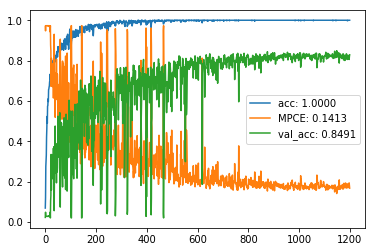

In [22]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['MPCE'])
plt.plot(hist.history['val_acc'])
plt.legend(['acc: %.4f'%max(hist.history['acc']),'MPCE: %.4f'%min(hist.history['MPCE']),'val_acc: %.4f'%max(hist.history['val_acc'])])

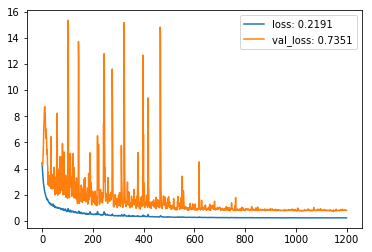

In [23]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss: %.4f'%min(hist.history['loss']),'val_loss: %.4f'%min(hist.history['val_loss'])])

## CAM

In [24]:
from keras import backend as K

In [25]:
model.load_weights('./weights/%s_weights.h5' % dataset_name)

In [26]:
model.layers

In [27]:
class_weights = model.layers[-1].get_weights()[0]
last_conv_acti = model.layers[-3]
cam_input = model.input

In [28]:
cam_func = K.function([cam_input, K.learning_phase()], [last_conv_acti.output])

In [29]:
CAM_INDEX = 2
cam_sample = X_train[CAM_INDEX][np.newaxis, ...]
cam_sample_Y = np.where(Y_train[CAM_INDEX]==1)[0][0]
cam_sample_Y

20

In [30]:
cam_output = cam_func([cam_sample, 1.])

In [31]:
cam_output[0].shape, class_weights.shape

((1, 174, 1, 256), (256, 37))

In [32]:
cam_matrix  = np.zeros((series_length, nb_classes), dtype=np.float32)

In [33]:
for i in range(0, cam_output[0].shape[1]):
    for j in range(class_weights.shape[1]):
        cam_matrix[i+1, j] = np.dot(cam_output[0][0, i, 0, :], class_weights[:, j])

In [34]:
cam_matrix = cam_matrix - cam_matrix.min(axis=0)

In [35]:
cam_matrix = cam_matrix / (cam_matrix.max(axis=0) - cam_matrix.min(axis=0))

In [36]:
import pandas as pd

In [37]:
sequence_df = pd.DataFrame(cam_sample[0,:,0],
                           index=range(cam_input.shape[1]),
                           columns=range(1))
cam_df = pd.DataFrame(cam_matrix, 
                      index=range(cam_matrix.shape[0]),
                      columns=range(cam_matrix.shape[1]))

Text(0.5,0.98,'CAM: sequence: 2, class: 20')

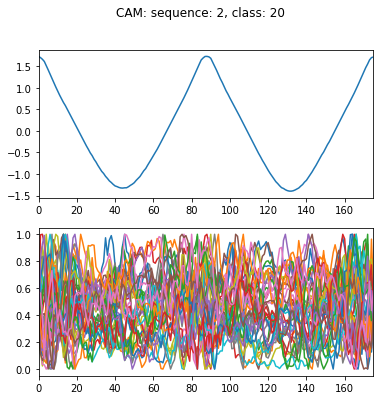

In [38]:
fig, axs = plt.subplots(2, 1, squeeze=False, figsize=(6, 6))
sequence_df.plot(subplots=False, legend=None, ax=axs[0][0])
cam_df.plot(subplots=False, legend=None, ax=axs[1][0])
fig.suptitle('CAM: sequence: %d, class: %d' % (CAM_INDEX, cam_sample_Y))